<a href="https://colab.research.google.com/github/ambideXtrous9/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.2/826.2 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 21.4 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import json
import os
import cv2
from torch.nn import functional as F
from pathlib import Path
import torchvision
from google.colab.patches import cv2_imshow
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch import nn
import PIL
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [4]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [5]:
_URL = 'http://images.cocodataset.org/zips/val2014.zip'
zip_dir = tf.keras.utils.get_file('/content/MSCOCOVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/MSCOCOVAL2014.zip'
!unzip -q $fname -d /content/

6645013297/6645013297 [==============================] - 108s 0us/step


In [6]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/QUESVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/QUESVAL2014.zip'
!unzip -q $fname -d /content/

3494929/3494929 [==============================] - 0s 0us/step


In [7]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/ANNOTVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/ANNOTVAL2014.zip'
!unzip -q $fname -d /content/

10518930/10518930 [==============================] - 0s 0us/step


In [8]:
with open(os.path.join('/content/', 'v2_OpenEnded_mscoco_val2014_questions.json'), 'r') as f:
    val_questions = json.load(f)['questions']
with open(os.path.join('/content/', 'v2_mscoco_val2014_annotations.json'), 'r') as f:
    val_answers = json.load(f)['annotations']

In [9]:
val_data = []
for question, annotation in zip(val_questions, val_answers):
    question_text = question['question']
    image_id = annotation['image_id']
    answer = annotation['answers'][0]['answer']
    image_filename = 'COCO_val2014_{:012d}.jpg'.format(image_id)
    image_path = os.path.join('/content/', 'val2014', image_filename)
    val_data.append({'question': question_text, 'image_path': image_path, 'answer': answer})

In [10]:
# Convert the array of dictionaries to a DataFrame
df = pd.DataFrame(val_data)

In [11]:
def has_three_channels(image_path):
    with PIL.Image.open(image_path) as img:
        return img.mode == 'RGB'

# Filter the DataFrame to keep only the images with 3 channels
df = df[df['image_path'].apply(has_three_channels)]

In [12]:
def show_sample(idx=0):
  print("Q : ",df.iloc[idx]['question'])
  image = cv2.imread(df.iloc[idx]['image_path'])
  image = cv2.resize(image, (224, 224))  
  cv2_imshow(image)
  print("A : ",df.iloc[idx]['answer'])

Q :  What is the background metal structure?


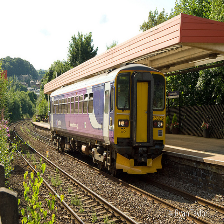

In [13]:
show_sample(100)

# **Model**

In [14]:
df = df[:5000]

In [15]:
train_df, val_df = train_test_split(df,test_size=0.1)

A :  trees


In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        
        return dict(img = image)

class ImageDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, batch_size=8, num_workers=4, transform=None):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.train_dataset = ImageDataset(self.train_df, transform=self.transform)
        self.val_dataset = ImageDataset(self.val_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return None # No test dataset


In [17]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [18]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 256 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 8, 8)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(256 * 8 * 8, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, 256 * 8 * 8)
        x = torch.sigmoid(self.fc(x))
        return x

In [19]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim: int = 64, lr: float = 0.0002, b1: float = 0.5, b2: float = 0.999):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_images = batch['img']
        batch_size = real_images.size(0)
        device = real_images.device
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        if optimizer_idx == 0: # Train generator
            z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
            gen_images = self.generator(z)
            g_loss = F.binary_cross_entropy(self.discriminator(gen_images), valid)
            self.log('g_loss', g_loss)
            return g_loss
        else: # Train discriminator
            z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
            gen_images = self.generator(z).detach()

            real_loss = F.binary_cross_entropy(self.discriminator(real_images), valid)
            fake_loss = F.binary_cross_entropy(self.discriminator(gen_images), fake)
            d_loss = (real_loss + fake_loss) / 2
            self.log('d_loss', d_loss)
            return d_loss

    def validation_step(self, batch, batch_idx):
        real_images = batch['img']
        batch_size = real_images.size(0)
        device = real_images.device
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
        gen_images = self.generator(z).detach()

        real_loss = F.binary_cross_entropy(self.discriminator(real_images), valid)
        fake_loss = F.binary_cross_entropy(self.discriminator(gen_images), fake)
        d_loss = (real_loss + fake_loss) / 2
        self.log('val_loss', d_loss, prog_bar=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        betas = (self.hparams.b1, self.hparams.b2)
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=betas)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        return [opt_g, opt_d], []

    def train_epoch_end(self):
        z = torch.randn(8, self.hparams.latent_dim, device=self.device)
        sample_imgs = self.generator(z)
        grid = torchvision.utils.make_grid(sample_imgs, nrow=4, normalize=True)
        self.logger.experiment.add_image('generated_images', grid, global_step=self.current_epoch)

    def validation_epoch_end(self, outputs):
        if len(outputs) > 0:
          avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
          self.log('val_loss', avg_val_loss, prog_bar=True)


In [20]:
BATCH_SIZE = 8
N_EPOCHS = 10

In [21]:
data_module = ImageDataModule(train_df, val_df, batch_size=BATCH_SIZE, 
                              num_workers=4, transform=transform)
data_module.setup()

In [22]:
model = GAN()

In [23]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min')

In [24]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.7 M 
1 | discriminator | Discriminator | 675 K 
------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.595     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1126: 'val_loss' reached 0.12170 (best 0.12170), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2252: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3378: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4504: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5630: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6756: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7882: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 9008: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 10134: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 11260: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [30]:
# Load the saved checkpoint
checkpoint_path = "/content/checkpoints/best_cp.ckpt"
model = GAN.load_from_checkpoint(checkpoint_path)

# Put the model in evaluation mode
model.eval()

GAN(
  (generator): Generator(
    (fc): Linear(in_features=64, out_features=16384, bias=True)
    (conv1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (discriminator): Discriminator(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=16384, out_features=1, bias=True)
  )
)

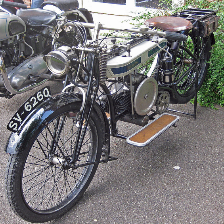

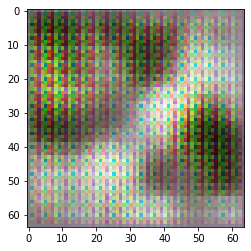

In [35]:
from PIL import Image

# Define the transformation to apply on the input image
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

path = "/content/val2014/COCO_val2014_000000000073.jpg"

img = cv2.imread(path)
img = cv2.resize(img, (224, 224))  
cv2_imshow(img)

# Load the image from file
image = Image.open(path)


# Apply the transformation
image = transform(image)

# Generate the image
with torch.no_grad():
    z = torch.randn(1, model.hparams.latent_dim, device=model.device)
    gen_image = model.generator(z)
    gen_image = (gen_image + 1) / 2  # Convert the output to a valid image range (0, 1)

# Display the generated image
import matplotlib.pyplot as plt
plt.imshow(gen_image[0].permute(1, 2, 0).cpu())
plt.show()
